In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

data = pd.read_csv("/content/customers.csv")
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [2]:
data.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [3]:
data = data.drop(columns=["ID"])
data.fillna({"Work_Experience": 0, "Family_Size": data["Family_Size"].median()}, inplace=True)
categorical_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

In [4]:
label_encoder = LabelEncoder()
data["Segmentation"] = label_encoder.fit_transform(data["Segmentation"])  # A, B, C, D -> 0, 1, 2, 3

In [5]:
X = data.drop(columns=["Segmentation"])
y = data["Segmentation"].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [9]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [11]:

class PeopleClassifier(nn.Module):
    def __init__(self, input_size):
        super(PeopleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        #self.fc3 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)  # 4 output classes (A, B, C, D)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc3(x)  # No activation, CrossEntropyLoss applies Softmax internally
        return x

In [12]:
model = PeopleClassifier(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [16]:
def train_model(model, train_loader, criterion, optimizer, epochs):
  for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [17]:
model = PeopleClassifier(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_model(model, train_loader, criterion, optimizer, epochs=100)

Epoch [10/100], Loss: 1.0977
Epoch [20/100], Loss: 1.2115
Epoch [30/100], Loss: 1.2707
Epoch [40/100], Loss: 1.3868
Epoch [50/100], Loss: 1.1643
Epoch [60/100], Loss: 1.0541
Epoch [70/100], Loss: 1.5469
Epoch [80/100], Loss: 1.3145
Epoch [90/100], Loss: 1.2320
Epoch [100/100], Loss: 1.0948


In [19]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        actuals.extend(y_batch.numpy())


In [20]:
accuracy = accuracy_score(actuals, predictions)*100
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(actuals, predictions, target_names=[str(i) for i in label_encoder.classes_])

In [26]:

print("NAME:CHARUKESH S")

print("REG NO: 212224230044")


print(f'Test Accuracy: {accuracy:.2f}%')

print("\nConfusion Matrix:\n", conf_matrix)

print("\nClassification Report:\n", class_report)

NAME:CHARUKESH S
REG NO: 212224230044
Test Accuracy: 46.87%

Confusion Matrix:
 [[414  83 157 199]
 [269 110 258 123]
 [135  53 419  92]
 [243  40  53 561]]

Classification Report:
               precision    recall  f1-score   support

           A       0.39      0.49      0.43       853
           B       0.38      0.14      0.21       760
           C       0.47      0.60      0.53       699
           D       0.58      0.63      0.60       897

    accuracy                           0.47      3209
   macro avg       0.46      0.46      0.44      3209
weighted avg       0.46      0.47      0.45      3209



NAME:CHARUKESH S
REG NO: 212224230044


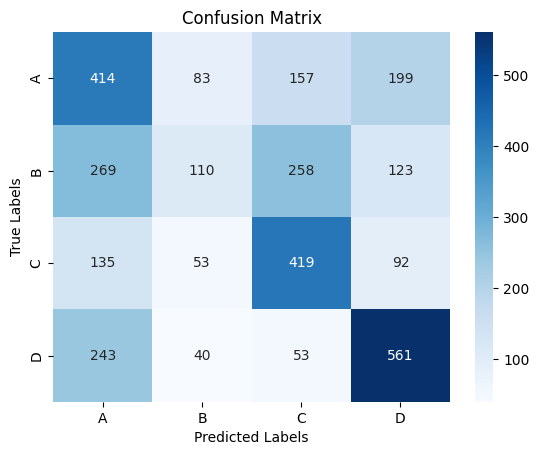

In [27]:
print("NAME:CHARUKESH S")

print("REG NO: 212224230044")
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,fmt='g')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [28]:
print("NAME:CHARUKESH S")

print("REG NO: 212224230044")
sample_input = X_test[12].clone().unsqueeze(0).detach().type(torch.float32)
with torch.no_grad():
    output = model(sample_input)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]

print(f'Predicted class for sample input: {predicted_class_label}')
print(f'Actual class for sample input: {label_encoder.inverse_transform([y_test[12].item()])[0]}')

NAME:CHARUKESH S
REG NO: 212224230044
Predicted class for sample input: D
Actual class for sample input: D
